# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

You can use ** Keras ** to implement your model. Read more at [keras.io](https://keras.io/).

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0)). You are not expected to model your architecture precisely using this model nor get the same performance levels, but this is more to show an exampe of an approach used to solve this particular problem. We encourage you to try out different architectures for yourself and see what works best for you. Here is a useful [forum post](https://discussions.udacity.com/t/goodfellow-et-al-2013-architecture/202363) discussing the architecture as described in the paper.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

## Implementation Overview


To complete the first step of this project we will need to:

0. [Load required libraries](#Load-required-libraries) and packages
1. [Download data](#Download-data) from the web
2. [Extract data](#Extract-data)
    1. Parse MNIST data format (idx3 file format)
3. [Explore and preprocess data](#Explore-and-preprocess-data):
    1. [Discover how the data is organized](#Discover-how-the-data-is-organized)
    2. [Check if training and test data are normally distributed across all labels](#Check-if-training-and-test-data-are-normally-distributed-across-all-labels)
    3. [Checking duplicate data in training and test dataset](#Checking-duplicate-data-in-training-and-test-dataset)
    4. [Check if data needs to be normalized](#Check-if-data-needs-to-be-normalized)
    5. [Introduce a blank character](#Introduce-a-blank-character)
    6. [Randomize data](#Randomize-training-data)
6. Create a [batch generator](#Batch-Generator) to feed inputs to our network.
    1. Besides generating batches, this generator has to **concatenate multiple images** in order to generate a sequence of digits
7. [Build model](#Build-Model)(s)
8. [Evaluate model](#Evaluate-Model)(s)
9. [Tune model](#Tune-Model)(s)



---------

[Back to Implementation Overview](#Implementation-Overview)

### Load required libraries

In [180]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import gzip
import idx2numpy
from IPython.display import display, Image
from scipy import ndimage
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from collections import Counter
from PIL import Image
import imagehash
import time

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

----------

[Back to Implementation Overview](#Implementation-Overview)

### Download data


In [5]:
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(url, target_folder, filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  global last_percent_reported

  notebook_dir = os.getcwd()
  os.chdir(target_folder)
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename)
    last_percent_reported = None
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    os.chdir(notebook_dir)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  os.chdir(notebook_dir)
  return filename

In [16]:
DATASETS_DIR = os.path.normpath('/input')
MNIST_URL = 'http://yann.lecun.com/exdb/mnist/'

mnist_train_images_filename = maybe_download(MNIST_URL, DATASETS_DIR, 'train-images-idx3-ubyte.gz', 9912422)
mnist_train_labels_filename = maybe_download(MNIST_URL, DATASETS_DIR, 'train-labels-idx1-ubyte.gz', 28881)
mnist_test_images_filename = maybe_download(MNIST_URL, DATASETS_DIR, 't10k-images-idx3-ubyte.gz', 1648877)
mnist_test_labels_filename = maybe_download(MNIST_URL, DATASETS_DIR, 't10k-labels-idx1-ubyte.gz', 4542)

Found and verified train-images-idx3-ubyte.gz
Found and verified train-labels-idx1-ubyte.gz
Found and verified t10k-images-idx3-ubyte.gz
Found and verified t10k-labels-idx1-ubyte.gz


----------

[Back to Implementation Overview](#Implementation-Overview)

### Extract data


In [10]:
def load_mnist(dataset_folder, filename):
    filepath = os.path.join(dataset_folder, filename)

    with gzip.open(filepath, 'rb') as f:
        file_content = f.read()
    
    print("Loaded %s to memory" % filepath)
    return file_content

----------

[Back to Implementation Overview](#Implementation-Overview)

### Explore and preprocess data


From [MNIST website](http://yann.lecun.com/exdb/mnist/):

> The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.
> 
> The data is stored in a very simple file format designed for storing vectors and multidimensional matrices. General info on this format is given at the end of this page, but you don't need to read that to use the data files.
All the integers in the files are stored in the MSB first (high endian) format used by most non-Intel processors. Users of Intel processors and other low-endian machines must flip the bytes of the header.
> 
> There are 4 files:
>
> - train-images-idx3-ubyte: training set images 
> - train-labels-idx1-ubyte: training set labels 
> - t10k-images-idx3-ubyte:  test set images 
> - t10k-labels-idx1-ubyte:  test set labels
> 
> The training set contains 60000 examples, and the test set 10000 examples.
> 
> The first 5000 examples of the test set are taken from the original NIST training set. The last 5000 are taken from the original NIST test set. The first 5000 are cleaner and easier than the last 5000.
>
> **TRAINING SET LABEL FILE (train-labels-idx1-ubyte):**
> ```
> [offset] [type]          [value]          [description] 
> 0000     32 bit integer  0x00000801(2049) magic number (MSB first) 
> 0004     32 bit integer  60000            number of items 
> 0008     unsigned byte   ??               label 
> 0009     unsigned byte   ??               label 
> ........ 
> xxxx     unsigned byte   ??               label
> ```
> The labels values are 0 to 9.
> 
> **TRAINING SET IMAGE FILE (train-images-idx3-ubyte):**
> ```
> [offset] [type]          [value]          [description] 
> 0000     32 bit integer  0x00000803(2051) magic number 
> 0004     32 bit integer  60000            number of images 
> 0008     32 bit integer  28               number of rows 
> 0012     32 bit integer  28               number of columns 
> 0016     unsigned byte   ??               pixel 
> 0017     unsigned byte   ??               pixel 
> ........ 
> xxxx     unsigned byte   ??               pixel
> ```
> Pixels are organized row-wise. Pixel values are 0 to 255. 0 means background (white), 255 means foreground (black).
> 
> **TEST SET LABEL FILE (t10k-labels-idx1-ubyte):**
> ```
> [offset] [type]          [value]          [description] 
> 0000     32 bit integer  0x00000801(2049) magic number (MSB first) 
> 0004     32 bit integer  10000            number of items 
> 0008     unsigned byte   ??               label 
> 0009     unsigned byte   ??               label 
> ........ 
> xxxx     unsigned byte   ??               label
> ```
> The labels values are 0 to 9.
> 
> **TEST SET IMAGE FILE (t10k-images-idx3-ubyte):**
> ```
> [offset] [type]          [value]          [description] 
> 0000     32 bit integer  0x00000803(2051) magic number 
> 0004     32 bit integer  10000            number of images 
> 0008     32 bit integer  28               number of rows 
> 0012     32 bit integer  28               number of columns 
> 0016     unsigned byte   ??               pixel 
> 0017     unsigned byte   ??               pixel 
> ........ 
> xxxx     unsigned byte   ??               pixel
> ```
> Pixels are organized row-wise. Pixel values are 0 to 255. 0 means background (white), 255 means foreground (black). 

#### Parsing idx format and loading data to memory

In [11]:
mnist_train_x = idx2numpy.convert_from_string(load_mnist(DATASETS_DIR, mnist_train_images_filename))
mnist_train_y = idx2numpy.convert_from_string(load_mnist(DATASETS_DIR, mnist_train_labels_filename))
mnist_test_x = idx2numpy.convert_from_string(load_mnist(DATASETS_DIR, mnist_test_images_filename))
mnist_test_y = idx2numpy.convert_from_string(load_mnist(DATASETS_DIR, mnist_test_labels_filename))

Loaded /input/train-images-idx3-ubyte.gz to memory
Loaded /input/train-labels-idx1-ubyte.gz to memory
Loaded /input/t10k-images-idx3-ubyte.gz to memory
Loaded /input/t10k-labels-idx1-ubyte.gz to memory


#### Discover how the data is organized

Training set shape: (60000, 28, 28) (60000,)
Test set shape: (10000, 28, 28) (10000,)
Sample image information:
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 166 255 187
    6   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 165 253 253
   13   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  15 191 253 216
    9   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  79 253 252

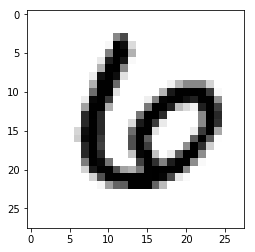

In [63]:
print("Training set shape:", mnist_train_x.shape, mnist_train_y.shape)
print("Test set shape:", mnist_test_x.shape, mnist_test_y.shape)
print("Sample image information:")
image_sample = mnist_train_x[np.random.randint(len(mnist_train_x))]
print(image_sample)
plt.figure()
plt.imshow(sample_image,cmap="binary")
plt.show()

#### Printing some images to visualize labels and training data

Image with label 6


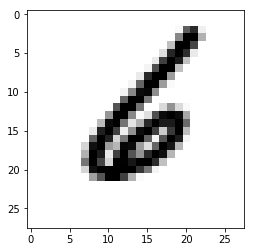

Image with label 3


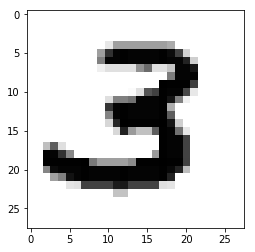

Image with label 4


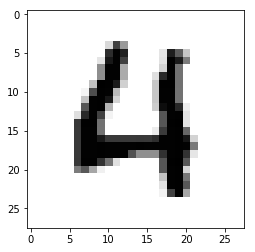

Image with label 4


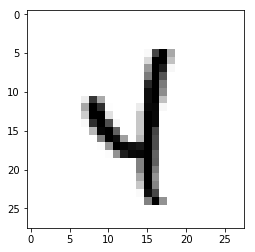

Image with label 4


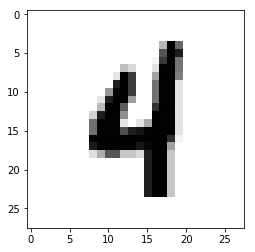

Image with label 6


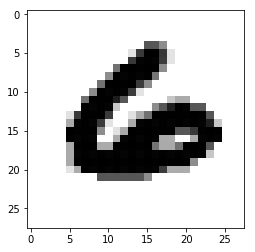

Image with label 1


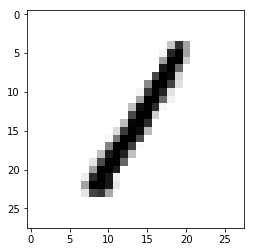

Image with label 2


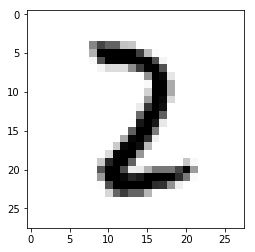

Image with label 2


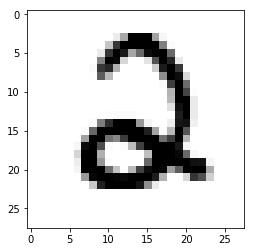

Image with label 6


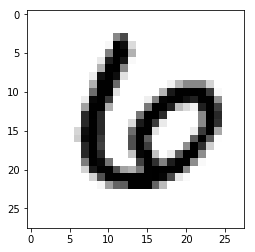

In [13]:
for i in range(10):
    sample_idx = np.random.randint(len(mnist_train_x))  # pick a random image index
    sample_image = mnist_train_x[sample_idx, :, :]  # extract a 2D slice
    sample_label = mnist_train_y[sample_idx]
    print("Image with label %s" % sample_label)
    plt.figure()
    plt.imshow(sample_image,cmap="binary")  # display it
    plt.show()

#### Check if training and test data are normally distributed across all labels

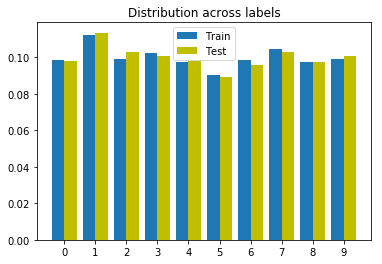

In [104]:
def plot_label_distribution(train_y, test_y):
    train_label_dist = Counter(train_y)
    norm_train_label_dist = Counter({k:v/train_y.shape[0] for k,v in train_label_dist.items()})
    test_label_distribution = Counter(test_y)
    norm_test_label_dist = Counter({k:v/test_y.shape[0] for k,v in test_label_distribution.items()})

    ind = np.arange(len(norm_train_label_dist))
    bar_width = .4

    plt.bar(ind, norm_train_label_dist.values(), width=bar_width, align='center')
    plt.bar(ind + bar_width, norm_test_label_dist.values(), width=bar_width, color='y', align='center')
    plt.xticks(ind + bar_width / 2, list(norm_train_label_dist.keys()))
    plt.legend(['Train', 'Test'])
    plt.show()

plt.title("Distribution across labels")
plot_label_distribution(mnist_train_y, mnist_test_y)

#### Checking duplicate data in training and test dataset

In [95]:
start = time.time()
train_hash = np.array([str(imagehash.dhash(Image.fromarray(np.uint8(x)))) for x in (mnist_train_x) ])
test_hash = np.array([str(imagehash.dhash(Image.fromarray(np.uint8(x)))) for x in (mnist_test_x) ])

_, train_unique = np.unique(train_hash, return_index=True)
_, test_unique = np.unique(test_hash, return_index=True)

mnist_train_unique_x = mnist_train_x[train_unique]
mnist_train_unique_y = mnist_train_y[train_unique]
train_unique_hash = train_hash[train_unique]

mnist_test_unique_x = mnist_test_x[test_unique]
mnist_test_unique_y = mnist_test_y[test_unique]
test_unique_hash = test_hash[test_unique]

test_in_train  = np.in1d(test_unique_hash, train_unique_hash)

test_keep  = ~test_in_train

train_dataset_clean = mnist_train_unique_x
train_labels_clean = mnist_train_unique_y
test_dataset_clean = mnist_test_unique_x[test_keep]
test_labels_clean  = mnist_test_unique_y[test_keep]
end = time.time() - start

train_train_overlap = mnist_train_x.shape[0] - train_unique.shape[0]
test_test_overlap = mnist_test_x.shape[0] - test_unique.shape[0]
test_train_overlap = test_in_train.sum()
total_overlap = train_train_overlap + test_test_overlap + test_train_overlap
total_overlap_percent = float(total_overlap) / (mnist_test_x.shape[0] + mnist_train_x.shape[0]) * 100
print("train -> train overlap: %d samples" % train_train_overlap)
print("test -> test overlap: %d samples" % test_test_overlap)
print("test  -> train overlap: %d samples" % test_train_overlap)
print("total overlap: %d samples (%.1f%%)" % (total_overlap, total_overlap_percent))
print("Elapsed: %ds" % end)

train -> train overlap: 1802 samples
test -> test overlap: 139 samples
test  -> train overlap: 318 samples
total overlap: 2259 samples (3.2%)
Elapsed: 8s


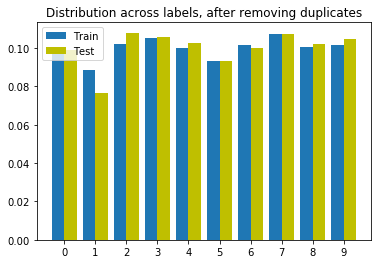

In [105]:
plt.title("Distribution across labels, after removing duplicates")
plot_label_distribution(train_labels_clean, test_labels_clean)

#### Check if data needs to be normalized

In [97]:
print("Describing data")
print("Train data: mean {} std {}".format(train_dataset_clean.mean(), train_dataset_clean.std()))
print("Test data: mean {} std {}".format(test_dataset_clean.mean(), test_dataset_clean.std()))

# Normalizing data:
train_dataset_clean_norm = (train_dataset_clean - 255.0 / 2) / 255.0
test_dataset_clean_norm = (test_dataset_clean - 255.0 / 2) / 255.0

print("Describing data after normalization")
print("Train data: mean {} std {}".format(train_dataset_clean_norm.mean(), train_dataset_clean_norm.std()))
print("Test data: mean {} std {}".format(test_dataset_clean_norm.mean(), test_dataset_clean_norm.std()))

Describing data
Train data: mean 33.70657400387558 std 78.93706037383204
Test data: mean 34.387574127418965 std 79.7309016893257
Describing data after normalization
Train data: mean -0.3678173568475465 std 0.30955709950522325
Test data: mean -0.36514676812776875 std 0.31267020270323803


#### Introduce a blank character

We need a blank character so we can build a series of digits in order to make a number. This can be achieved by training the model on a "blank" character, or by feeding it the length of the image input.


**SO FAR I DONT NEED A BLANK CHARACTER. INSTEAD I WILL USE LENGTH + PREVENT BACKPROPAGATION FOR NUMBERS WITH LESS THAN 5 DIGITS**




As we've seen above, the [distribution of labels across training and testing sets](#Check-if-training-and-test-data-are-normally-distributed-across-all-labels) is close to 10%. To keep everything balanced while introducing a new blank character, we would need 6,000 training samples and 1,000 testing samples of this character.

To generate a blank character, we will take random existing characters and apply a transformation which nullify the digit itself, while leaving behind some random noise.

#### Randomize, One Hot Encode and Split Data

In [202]:
def randomize(data, labels):
    permutation = np.random.permutation(data.shape[0])
    return data[permutation, :, :], labels[permutation]

# Randomizing
train_x, train_y = randomize(train_dataset_clean_norm, train_labels_clean)
test_x, test_y = randomize(test_dataset_clean_norm, test_labels_clean)

# One Hot Encoding
from keras.utils import to_categorical

num_classes = 10
train_y = to_categorical(train_y, num_classes)
test_y = to_categorical(test_y, num_classes)

print("Shapes after one hot encoding: ", train_y.shape, test_y.shape)

# Split Data
valid_size = round(len(train_x) / 10)
print("Valid Size: ", valid_size)
valid_x, train_x = train_x[:valid_size], train_x[valid_size:]
valid_y, train_y = train_y[:valid_size], train_y[valid_size:]

print("Valid shape:", valid_x.shape, valid_y.shape)

Shapes after one hot encoding:  (58198, 10) (9543, 10)
Valid Size:  5820
Valid shape: (5820, 28, 28) (5820, 10)


----------

[Back to Implementation Overview](#Implementation-Overview)

### Batch Generator


In [224]:
image_size = 28
max_length = 5

def array_to_integer(arr):
    length = arr.shape[0]
    n = 0
    for i, v in np.ndenumerate(arr):
        n += v * 10**(length - (i[0] + 1))
    return n

def generate_batch(data, labels, batch_size):
    batch_data = np.ndarray((batch_size, image_size, image_size * max_length), dtype=np.float32)
    batch_lengths = np.ndarray(batch_size, dtype=np.int32)
    batch_labels = np.ndarray((batch_size, max_length, num_classes), dtype=np.int32)
    
    for i in range(batch_size):
        length = np.random.randint(1, max_length + 1)
        numbers = np.random.choice(range(data.shape[0]), max_length)
        batch_data[i] = np.concatenate(data[[numbers]], axis=1)
        batch_lengths[i] = length
        batch_labels[i] = labels[[numbers]]
    
    return (batch_data, batch_lengths, batch_labels)

Batch shapes:  (5, 28, 140) (5,) (5, 5, 10)

Printing batch data:
Label:  [6, 0, 1, 9, 8]
Length: 4


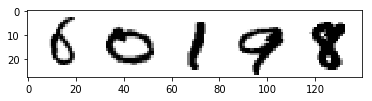

Label:  [8, 1, 0, 1, 7]
Length: 4


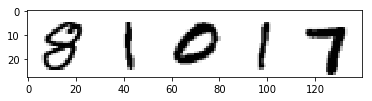

Label:  [0, 6, 8, 8, 0]
Length: 4


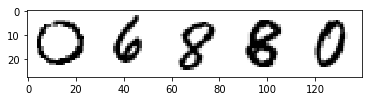

Label:  [4, 1, 9, 0, 1]
Length: 5


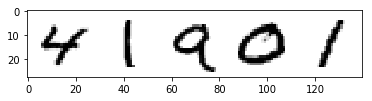

Label:  [3, 8, 7, 7, 5]
Length: 3


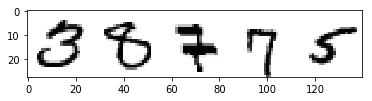

In [225]:
batch_x, batch_l, batch_y = generate_batch(train_x, train_y, 5)


print("Batch shapes: ", batch_x.shape, batch_l.shape, batch_y.shape)
print()
print("Printing batch data:")

n = 0
for image in batch_x:
    print("Label: ", [np.argmax(x) for x in batch_y[n]])
    print("Length: %d" % batch_l[n])
    plt.figure()
    plt.imshow(image, cmap="binary")
    plt.show()
    n += 1

----------

[Back to Implementation Overview](#Implementation-Overview)

### Build Model


In [226]:
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import MaxoutDense
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Activation
from keras.layers.core import Dropout

# This model uses the architecture of Goodfellow et al. 2013

model = Sequential(
    Input(shape=(max_length, image_size, image_size)),
    Conv2D(3, 5, padding="same"),
    MaxPool2D(strides=2),
    Dropout(.1),
#    MaxoutDense()
    Activation("relu"),
)

TypeError: The added layer must be an instance of class Layer. Found: Tensor("input_2:0", shape=(?, 5, 28, 28), dtype=float32)

----------

[Back to Implementation Overview](#Implementation-Overview)

### Evaluate Model


----------

[Back to Implementation Overview](#Implementation-Overview)

### Tune Model


### Question 1
_What approach did you take in coming up with a solution to this problem?_

**Answer:** 

### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

**Answer:**

### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

**Answer:**

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:**

### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:**

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:**

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

**Answer:**

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:**

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** Leave blank if you did not complete this part.

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:**

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your optional code implementation goes here.
### Feel free to use as many code cells as needed.



### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.